In [2]:
import sys
sys.path.insert(0, "..")

import random
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import foraging_toolkit as ft
import torch.nn.functional as F
import pyro.distributions as dist
import pyro.optim as optim
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean, init_to_value
from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)


import foraging_toolkit as ft

## Random birds

### Running a simulation

In [3]:
random.seed(2)
np.random.seed(2)
# generate a simulation object with fixed 
# simulation parameters
rbirds = ft.RandomBirds(grid_size= 30,
                        step_size_max= 4,
                        probabilities= [1, 2, 3, 2, 1, 2, 3, 2, 1],
                        num_birds= 3,
                        num_frames= 10,
                        num_rewards= 15,
                        grab_range= 3)

#run a particular simulation with these parameters
rbirds()

In [4]:
# you have created birds and rewards in a space-time grid

#each row contains the x and y coordinates of a bird at a particular time
rbirds.birdsDF.head()

,x,y,bird,time
0,14.0,16.0,1,1
1,10.0,16.0,1,2
2,11.0,13.0,1,3
3,10.0,13.0,1,4
4,9.0,11.0,1,5


In [5]:
# each row contains the x and y coordinates of a reward at a particular time
rbirds.rewardsDF.head()

,x,y,time
0,21,17,1
1,6,9,1
2,11,7,1
3,9,11,1
4,27,6,1


In [6]:
# look at just the birds

ft.animate_birds(rbirds, plot_rewards=True,
                  width = 600, height = 600, point_size = 10)


### Transformed data

In [7]:
# let's add transformed data

rbirds_transformed = ft.transform_birds(rbirds)

In [8]:
# now we can plot food traces in time:

ft.animate_birds(rbirds_transformed, plot_rewards=True, width = 600,
                  height = 600, point_size = 10,plot_traces=True)

In [9]:
# we can also plot visibility, for one bird at a time
# as multiple birds' visibility is hard to see 
# let's say, bird 2

ft.animate_birds(rbirds_transformed, plot_rewards=True, width = 600,
                  height = 600, point_size = 10, 
                  plot_visibility=2, plot_traces=True)


In [9]:
# we can plot proximity score
# bird 2 again

ft.animate_birds(rbirds_transformed, plot_rewards=True, width = 600,
                  height = 600, point_size = 10, plot_proximity=2)

### Inference


In [10]:
# prepare data

df = rbirds_transformed.transformationsDF.dropna()

data = torch.tensor(df[["proximity_standardized",
                         "trace_standardized", 
                         "visibility", "how_far_squared_scaled"]].values, dtype=torch.float32)

prox, tr, vis, hf = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

In [11]:
# visualise key predictors:

ft.visualise_bird_predictors(tr, prox, hf)

In [18]:
#setting up the MCMC inference method

def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def mcmc_training(model, *args):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=400)
    mcmc.run(*args)

    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    for site, values in summary(hmc_samples).items():
        if site in ["t","p"]:
            print("Site: {}".format(site))
            print(values, "\n")

    return hmc_samples

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning:

Can't initialize NVML



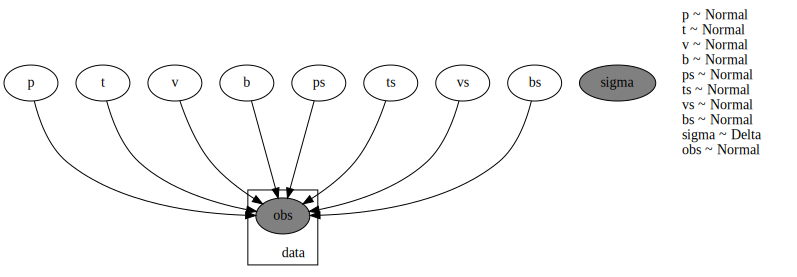

In [13]:
# define the model

def model_sigmavar(prox, tr, vis, hf):
    p = pyro.sample("p", dist.Normal(0, .3))
    t = pyro.sample("t", dist.Normal(0, .3))
    v = pyro.sample("v", dist.Normal(0, .3))
    b = pyro.sample("b", dist.Normal(.5, .3))

    ps = pyro.sample("ps", dist.Normal(0, .3))
    ts = pyro.sample("ts", dist.Normal(0, .3))
    vs = pyro.sample("vs", dist.Normal(0, .3))
    bs = pyro.sample("bs", dist.Normal(.2, .3))


    sigmaRaw = bs + ps * prox + ts * tr + vs * vis
    sigma = pyro.deterministic("sigma", F.softplus(sigmaRaw))
    mean = b + p * prox + t * tr + v * vis

    with pyro.plate("data", len(hf)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=hf)

pyro.render_model(model_sigmavar, model_args=(prox, tr, vis, hf),
                        render_distributions=True)

In [14]:
# Inference with SVI
# note how long this takes
# and compare with MCM 

guide = AutoMultivariateNormal(model_sigmavar, init_loc_fn=init_to_mean)
svi = SVI(model_sigmavar,
        guide,
        optim.Adam({"lr": .01}),
        loss=Trace_ELBO())

iterations = []
losses = []

pyro.clear_param_store()
num_iters = 1000
for i in range(num_iters):
    elbo = svi.step(prox, tr, vis, hf)
    iterations.append(i)
    losses.append(elbo)
    if i % 200 == 0:
        logging.info("Elbo loss: {}".format(elbo))


Elbo loss: 5690.656310558319
Elbo loss: -7131.257479608059
Elbo loss: -6479.764152646065
Elbo loss: -9100.919750392437
Elbo loss: -9015.746829688549


In [15]:
df = pd.DataFrame({'iterations': iterations, 'ELBO Loss': losses})

fig = px.line(df, x='iterations', y='ELBO Loss')

fig.update_layout(
    title="ELBO Loss over iterations",
    xaxis_title="iterations",
    yaxis_title="ELBO Loss",
    template="plotly_dark", 
    showlegend=False,  
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)

fig.show()

In [16]:
# inspect the summary of the SVI posterior
# of key interest: t and p

num_samples = 1000
predictive = Predictive(model_sigmavar, guide=guide, 
                        num_samples=num_samples,
                        return_sites = ["t", "p"])
random_sigmavar = {k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
            for k, v in predictive(prox, tr, vis, hf).items()
            if k != "obs"}

for site, values in summary(random_sigmavar).items():
            print("Site: {}".format(site))
            print(values, "\n")

Site: p
      mean       std        5%       25%       50%      75%       95%
0  0.00083  0.004014 -0.005775 -0.001687  0.000824  0.00347  0.007489 

Site: t
       mean       std       5%       25%       50%       75%       95%
0  0.003393  0.005368 -0.00554 -0.000075  0.003342  0.006979  0.012123 



In [19]:
# as a sanity check
# compare with the results 
# from the MCMC method

# warning: MCMC training might take a bit of time to run
random_sigmavar_mcmc = mcmc_training(model_sigmavar, prox, tr, vis, hf)

Sample: 100%|██████████| 1400/1400 [02:12, 10.59it/s, step size=1.08e-01, acc. prob=0.921]

Site: p
       mean       std        5%       25%       50%       75%       95%
0  0.001959  0.000792  0.000687  0.001452  0.001957  0.002469  0.003221 

Site: t
       mean       std        5%       25%       50%       75%       95%
0  0.005002  0.000959  0.003389  0.004343  0.005009  0.005672  0.006618 



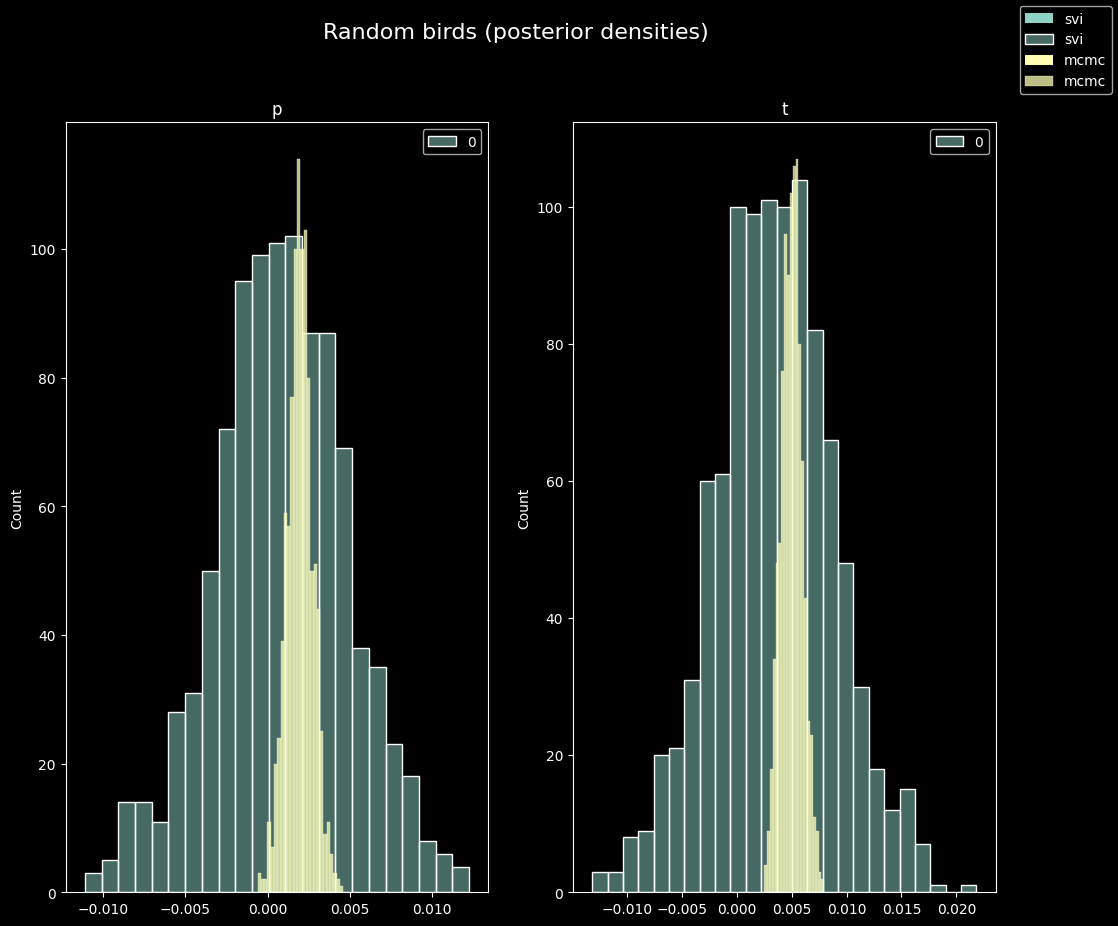

In [20]:
# plot the marginal posterior distributions
# for the coefficients of interest

sites = ["p", "t"]
plt.style.use("dark_background")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
fig.suptitle("Random birds (posterior densities)", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(random_sigmavar[site], ax=ax, label="svi")
    sns.histplot(random_sigmavar_mcmc [site], ax=ax, label="mcmc")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');